In [1]:
%load_ext autoreload
%autoreload 2

%cd ..

/Users/rubenbroekx/Documents/Projects/radix-co2-reduction


# Tillage Classification - Random Forest

In [2]:
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from collections import Counter
from pathlib import Path
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

from src.radix_co2_reduction.tillage_detection.models import FieldRF
from src.radix_co2_reduction.data import load_data, get_tillage_label

## Load Data

Load in all data used for the classification.

In [3]:
# Root data folder
DATA = Path.home() / 'data/agoro/2021-05-19'

In [4]:
# Fetch field-IDs
all_ids = glob(str(DATA / '*/ndti.png'))
all_ids = [int(i.split('/')[-2]) for i in all_ids]

In [5]:
# Load in all data
meta_data = {}
for i in all_ids:
    with open(DATA / f"{i}/meta.json", 'r') as f:
        meta_data[i] = json.load(f)
        
# Extract tillage types
tillage_types = {k:v['tillage'] for k,v in meta_data.items()}

# Get total number of fields
print(f"Total number of data samples:", len(tillage_types))

# Show classes
print(f"Number of samples by class:")
for k,v in Counter(tillage_types.values()).items():
    print(f" - {k}: {v}")

Total number of data samples: 966
Number of samples by class:
 - Conv.-Till: 666
 - No-Till: 300


In [6]:
N_TEST = 50

# Split into training and testing
no_till = [field_id for field_id,label in tillage_types.items() if label == 'No-Till']
conv_till = [field_id for field_id,label in tillage_types.items() if label == 'Conv.-Till']

# Test-set
test = no_till[:N_TEST] + conv_till[:N_TEST]
print(f"Test-size: {len(test)}")
train = no_till[N_TEST:] + conv_till[N_TEST:]
print(f"Train-size: {len(train)}")

Test-size: 100
Train-size: 866


## Train the Classifier

Train a Random Forest classifier on field-level data. 

In [7]:
# Load in and initialise the model
model = FieldRF(
    models_path=Path.cwd() / 'models',
)

Loaded existing cloud-filter!


In [10]:
# Initialise feature mask
model.init_feature_mask()

# Load in the features and corresponding labels
features, labels = [], []
for field_id in tqdm(train, desc='Loading data'):
    data = load_data(DATA / f'{field_id}')
    features.append(model.get_features(data))
    labels.append(get_tillage_label(DATA / f'{field_id}'))

# Train the model
model.optimise_feature_mask(
    features=features,
    labels=labels,
)

Loading data: 100%|██████████| 866/866 [01:01<00:00, 14.04it/s]


In [11]:
# Load in the features and corresponding labels
features, labels = [], []
for field_id in tqdm(train, desc='Loading data'):
    data = load_data(DATA / f'{field_id}')
    features.append(model.get_features(data))
    labels.append(get_tillage_label(DATA / f'{field_id}'))

# Train the model
model.train(
    features=features,
    labels=labels,
)

Loading data: 100%|██████████| 866/866 [01:01<00:00, 14.01it/s]


Loading data: 100%|██████████| 100/100 [00:08<00:00, 12.37it/s]


Accuracy: 0.79
  Recall: 0.88
F1-score: 0.8073394495412843


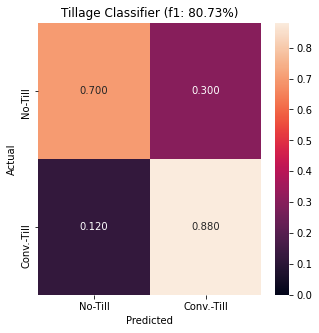

Misclassified
 - 93785
 - 93912
 - 103046
 - 93915
 - 68546
 - 94509
 - 102791
 - 67951
 - 103478
 - 79608
 - 68114
 - 79299
 - 80333
 - 67950
 - 103810
 - 103874
 - 57935
 - 68149
 - 79434
 - 67993
 - 94994


In [12]:
# Load in the features and corresponding labels
features, labels = [], []
for field_id in tqdm(test, desc='Loading data'):
    data = load_data(DATA / f'{field_id}')
    features.append(model.get_features(data))
    labels.append(get_tillage_label(DATA / f'{field_id}'))

# Evaluate the model
preds = model.eval(
    features=features,
    labels=labels,
)

# Show confusion matrix
arr = confusion_matrix(labels, preds, normalize='true')
plt.figure(figsize=(5, 5))
sns.heatmap(arr, annot=True, fmt=".3f", vmin=0)
title = f"Tillage Classifier (f1: {100*f1_score(labels, preds):.2f}%)"
plt.title(title)
plt.xlabel("Predicted")
plt.xticks([0.5, 1.5], ['No-Till', 'Conv.-Till'])
plt.ylabel("Actual")
plt.yticks([0.5, 1.5], ['No-Till', 'Conv.-Till'])
plt.show()

# Print out the misclassified
print("Misclassified")
for i,l,p in zip(test,labels,preds):
    if l != p:
        print(f" - {i}")

In [12]:
# Save the model
model.save()

In [20]:
# Example on inference
with open(Path.home() / 'data/agoro/2021-05-02/104403/samples/sentinel2.json', 'r') as f:
    sample = json.load(f)
print(f"Prediction on 104403 (should be False):", model(sample))

with open(Path.home() / 'data/agoro/2021-05-02/103077/samples/sentinel2.json', 'r') as f:
    sample = json.load(f)
print(f"Prediction on 103077 (should be True):", model(sample))

Prediction on 104403 (should be False): False
Prediction on 103077 (should be True): True


## Cross Validation

In [13]:
# Load in the data
features, labels = [], []
for field_id in tqdm(all_ids, desc='Loading data'):
    data = load_data(DATA / f'{field_id}')
    features.append(model.get_features(data))
    labels.append(get_tillage_label(DATA / f'{field_id}'))

Loading data: 100%|██████████| 966/966 [01:09<00:00, 13.94it/s]


In [14]:
# Balance
sm = RandomOverSampler(random_state=42)
features, labels = sm.fit_resample(features, labels)

In [15]:
# Cross Validation
clf = RandomForestClassifier()
scores = cross_val_score(
    clf, 
    features, 
    labels, 
    cv=5,
)
sum(scores)/len(scores)

0.8941567401650193